# 10.1 Structural Analysis of USD/JPY Time Series
<h3><span style="color:#800000;"><strong>Authored by:</strong> <em>Alexandre Mathias DONNAT, Sr</em></span></h3>

**Goal of this notebook & Research Motivation**:

*What drives the underlying structure of USD/JPY?*

FX markets are known for high liquidity, noisy dynamics, low predictability, and weak seasonal behaviour. Before attempting any forecasting or advanced modeling, we must first understand the fundamental structure of the time series.

**This notebook**: 

- Decompose the series into trend, seasonal, and residual components (STL decomposition).
- Assess stationarity, a prerequisite for many time-series models (ADF, KPSS, rolling statistics).
- Study linear dependence through AR/MA/ARIMA models (ACF/PACF identification, Maximum Likelihood estimation, AIC/BIC, residual diagnostics).
- Analyze the frequency domain using spectral methods (periodogram, Fast Fourrier Transform).
- Apply linear filters and smoothing techniques (moving averages, exponential smoothing, Slutzky–Yule effect).


This structural exploration lays the groundwork for Notebook 10.2, where we model USD/JPY using state-space techniques and the Kalman filter.


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from scipy.signal import periodogram
from scipy.fft import fft
from pandas.errors import SettingWithCopyWarning

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="A date index has been provided, but it has no associated frequency")
warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge")
warnings.filterwarnings("ignore", message="The test statistic is outside of the range")

# 1. Data Preparation & Initial Exploration

We download daily USD/JPY data from Yahoo Finance.
We analyse:
- price levels,
- log-returns,
- rolling statistics.

These first diagnostics reveal whether the series exhibits long-term structure or behaves mostly as a stochastic process.

In [3]:
data = yf.download("JPY=X", start="2010-01-01", end="2025-01-01")
data = data["Close"].dropna()
returns = np.log(data).diff().dropna()

[*********************100%***********************]  1 of 1 completed


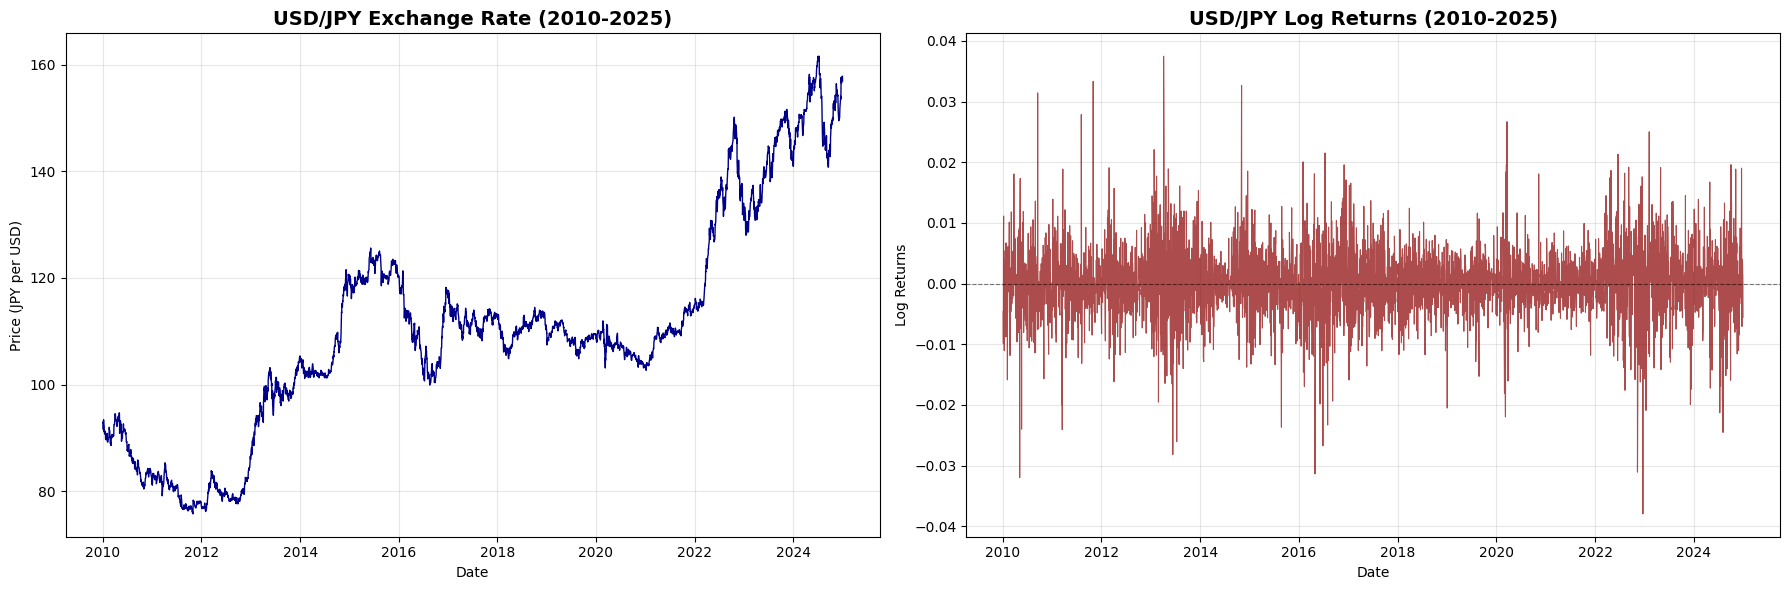

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].plot(data.index, data.values, linewidth=1, color='darkblue')
axes[0].set_title("USD/JPY Exchange Rate (2010-2025)", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Price (JPY per USD)")
axes[0].grid(alpha=0.3)

axes[1].plot(returns.index, returns.values, linewidth=0.8, color='darkred', alpha=0.7)
axes[1].set_title("USD/JPY Log Returns (2010-2025)", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Log Returns")
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [5]:
print(f"USD/JPY Price Series (2010-2025)")
print(f"Shape: {data.shape}")
print(f"First observation: {data.index[0]} = {data.iloc[0].values[0]:.2f}")
print(f"Last observation: {data.index[-1]} = {data.iloc[-1].values[0]:.2f}")
print(f"\nDescriptive Statistics:\n{data.describe()}")

print(f"\nLog Returns Descriptive Statistics:\n{returns.describe()}")

USD/JPY Price Series (2010-2025)
Shape: (3908, 1)
First observation: 2010-01-01 00:00:00 = 92.92
Last observation: 2024-12-31 00:00:00 = 156.99

Descriptive Statistics:
Ticker        JPY=X
count   3908.000000
mean     110.154479
std       20.107279
min       75.739998
25%       99.854750
50%      109.313999
75%      118.918751
max      161.621002

Log Returns Descriptive Statistics:
Ticker        JPY=X
count   3907.000000
mean       0.000134
std        0.005793
min       -0.037961
25%       -0.002939
50%        0.000228
75%        0.003168
max        0.037485


USD/JPY generally displays long multiyear regimes, e.g. the yen weakening strongly after 2012 (Abenomics). Returns appear far more stationary than prices, consistent with FX market microstructure. Rolling variance may show volatility clusters. This motivates deeper decomposition and stationarity tests.

# 2. Decomposition & Stationarity Analysis

## 2.1 Trend and Seasonal Decomposition

We apply STL decomposition:

$$Y_t = T_t + S_t + R_t,$$

where $T_t$ is trend, $S_t$ the seasonal component, $R_t$ the residual.


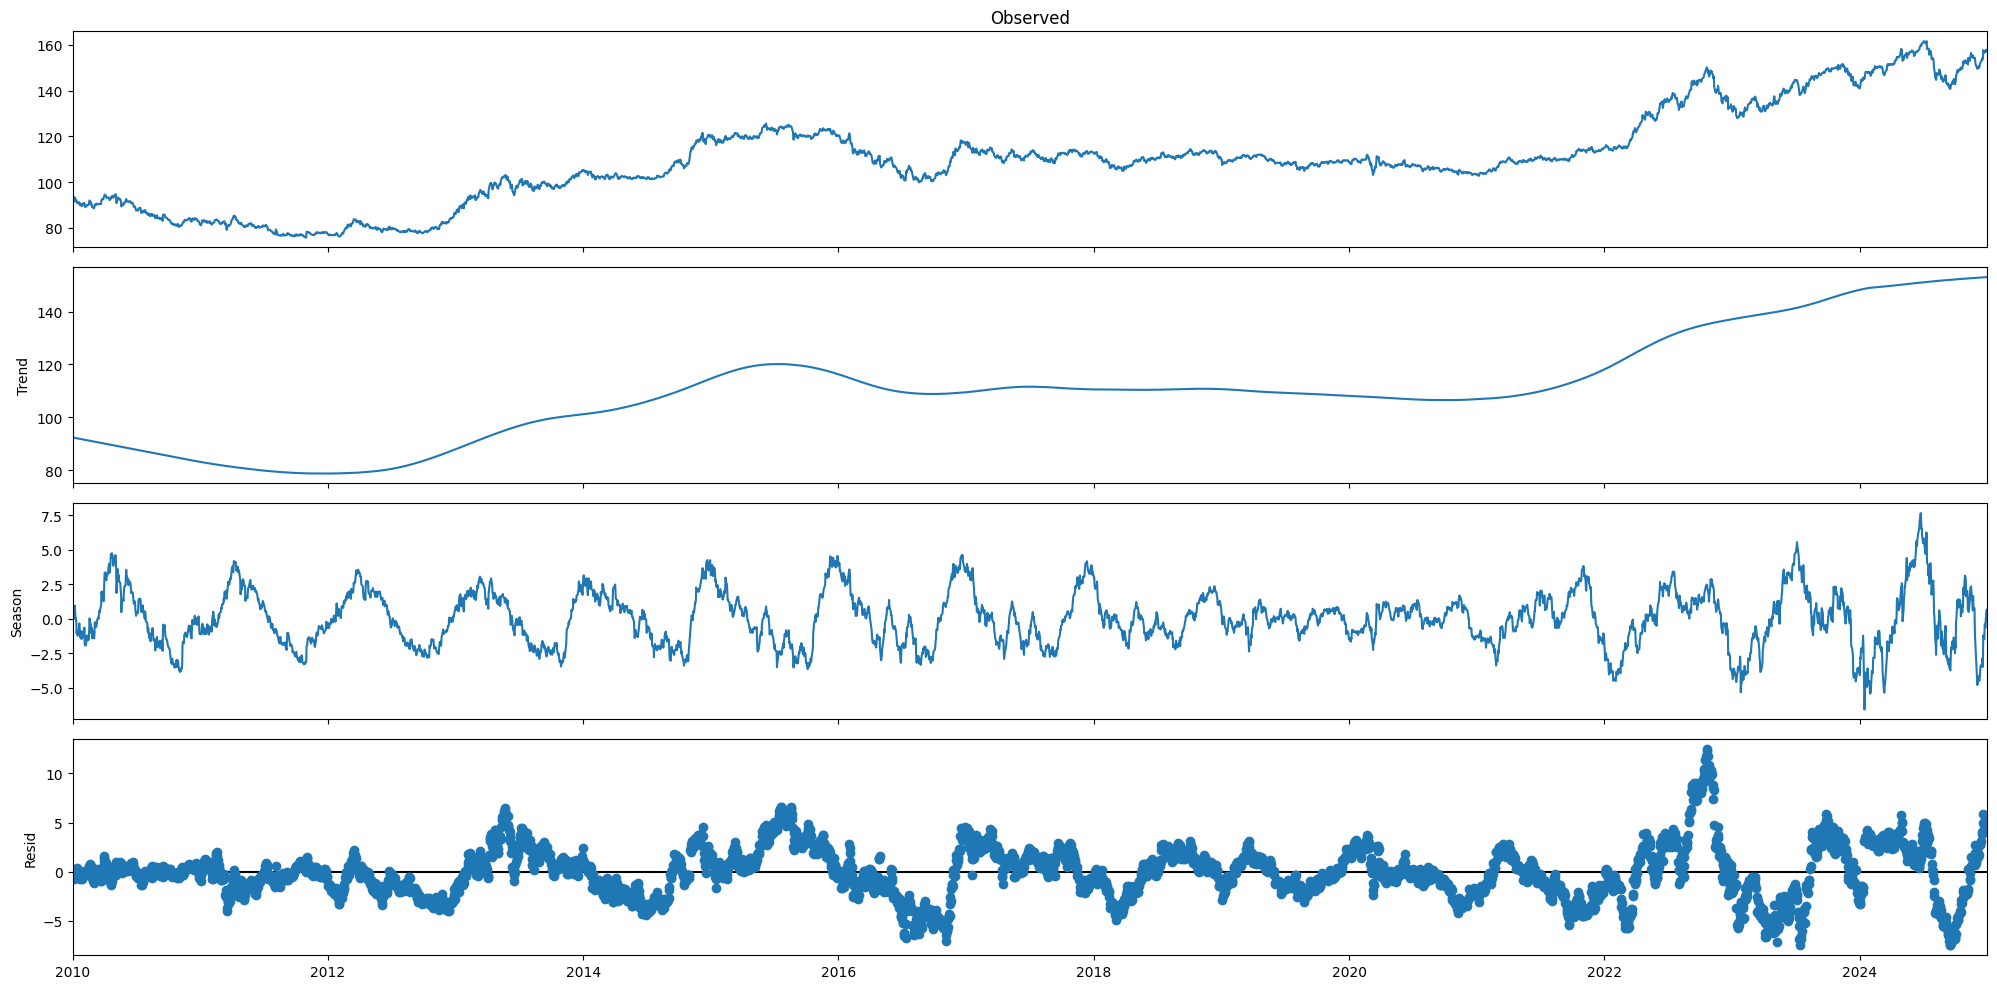

In [6]:
stl = STL(data, period=252)
res = stl.fit()
fig = res.plot()
fig.set_size_inches(20, 10)
plt.tight_layout()
plt.show()

FX markets rarely exhibit strong regular seasonality; accordingly, the extracted seasonal component appears weak and unstable over time. In contrast, the trend clearly captures long-term macroeconomic cycles, such as the yen depreciation phase between 2012 and 2015 and subsequent strengthening during risk-off episodes. This visual evidence suggests that the price level is non-stationary, a hypothesis that will be formally tested in the next section.

## 2.2 Stationarity Tests

We test stationarity using ADF and KPSS.

In [7]:
def adf_test(series):
    return adfuller(series, autolag='AIC')[1]

def kpss_test(series):
    return kpss(series, regression='c')[1]

print("ADF on prices:", adf_test(data))
print("ADF on returns:", adf_test(returns))
print("KPSS on prices:", kpss_test(data))
print("KPSS on returns:", kpss_test(returns))

ADF on prices: 0.9677353089470744
ADF on returns: 0.0
KPSS on prices: 0.01
KPSS on returns: 0.1


The decomposition already suggested that USD/JPY prices do not revert to a stable level. The stationarity tests confirm this diagnosis: the ADF test on prices yields a p-value of 0.968, failing to reject the null hypothesis of a unit root, while the KPSS test returns a p-value of 0.01, explicitly rejecting stationarity. In contrast, returns exhibit clear stationarity in mean, with an ADF p-value of 0.000 and a KPSS p-value of 0.10, which does not reject stationarity. 

This configuration is typical of FX markets: returns are stationary in mean but remain heteroskedastic, with pronounced volatility clustering. Consequently, all subsequent modeling should be performed on returns (or differenced prices), not on the raw price series.

## 2.3 Turning Point Test

A simple measure of randomness: how often the direction changes.

We expect FX returns to behave close to a random walk (high randomness).

In [8]:
tp = np.sum(np.sign(returns).diff().fillna(0) != 0)
tp_ratio = tp / len(returns)
tp_ratio

Ticker
JPY=X    0.529306
dtype: float64

The high turning-point ratio (0.53) indicates strong short-term directional noise. This confirms that USD/JPY exhibits weak short-term trend persistence, making short-horizon forecasting particularly difficult.

# 3. Linear Dependencies: AR, MA, ARMA, ARIMA

## 3.1 Autocorrelation Structure

We compute ACF and PACF for returns.

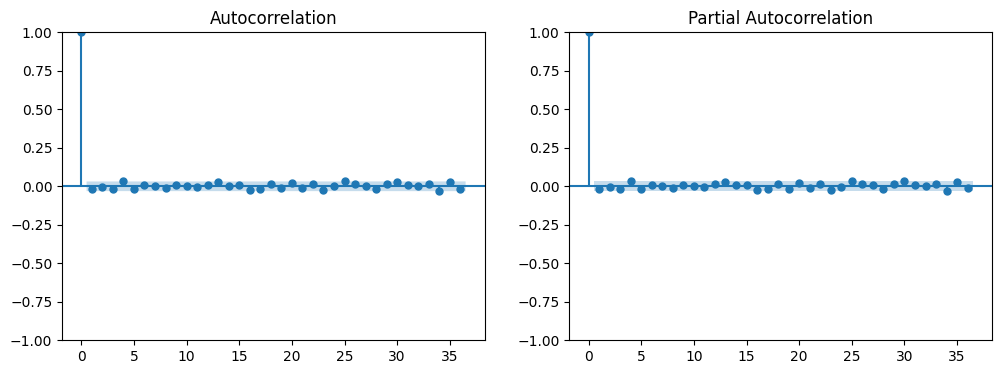

In [9]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_acf(returns, ax=ax[0])
plot_pacf(returns, ax=ax[1])
plt.show()

The ACF shows that almost all autocorrelations lie within the confidence bounds, confirming the near absence of linear dependence in FX returns. A very slight negative first-lag autocorrelation can be observed, which is consistent with well-known microstructure effects (bid–ask bounce). The PACF displays no significant spikes at higher lags, indicating the absence of long-range memory. This pattern suggests that, at the mean level, FX returns are close to white noise and that only very low-order AR or MA components (if any) should be considered in the model specification.

## 3.2 Fit ARIMA models

We try ARIMA(1,0,1) and compare with ARIMA(0,0,0).

In [10]:
model = ARIMA(returns, order=(1,0,1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  JPY=X   No. Observations:                 3907
Model:                 ARIMA(1, 0, 1)   Log Likelihood               14582.488
Date:                Wed, 10 Dec 2025   AIC                         -29156.976
Time:                        12:46:47   BIC                         -29131.894
Sample:                             0   HQIC                        -29148.075
                               - 3907                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   8.81e-05      1.523      0.128   -3.85e-05       0.000
ar.L1          0.6859      0.285      2.406      0.016       0.127       1.245
ma.L1         -0.7027      0.279     -2.522      0.012      -1.249      -0.157
sigma2      3.349e-05   4.42e-07     75.828      0.000    3.26e-05    3.44e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2481.17
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                            -0.08
Prob(H) (two-sided):                  0.05   Kurtosis:                         6.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Unlike the typical case where AR terms are often insignificant in FX, the AR(1) coefficient here is statistically significant (p = 0.016), indicating a small but detectable short-term linear dependence in returns. 

The MA(1) term is also significant (p = 0.012) and negative, which is consistent with microstructure effects such as bid–ask bounce and short-lived shock correction. 

However, the very low variance (σ² ≈ 3.3e−5), the extreme Jarque–Bera statistic (2481), and the excess kurtosis (6.9) confirm that returns remain strongly non-Gaussian and heteroskedastic. As expected in FX markets, information criteria (AIC/BIC) still favour very low-order ARMA structures, reinforcing the idea that predictability in the mean is weak and that most of the dynamics lies in the conditional variance rather than in the conditional mean.

# 4. Spectral Analysis
## 4.1 Fourier Transform & Periodogram

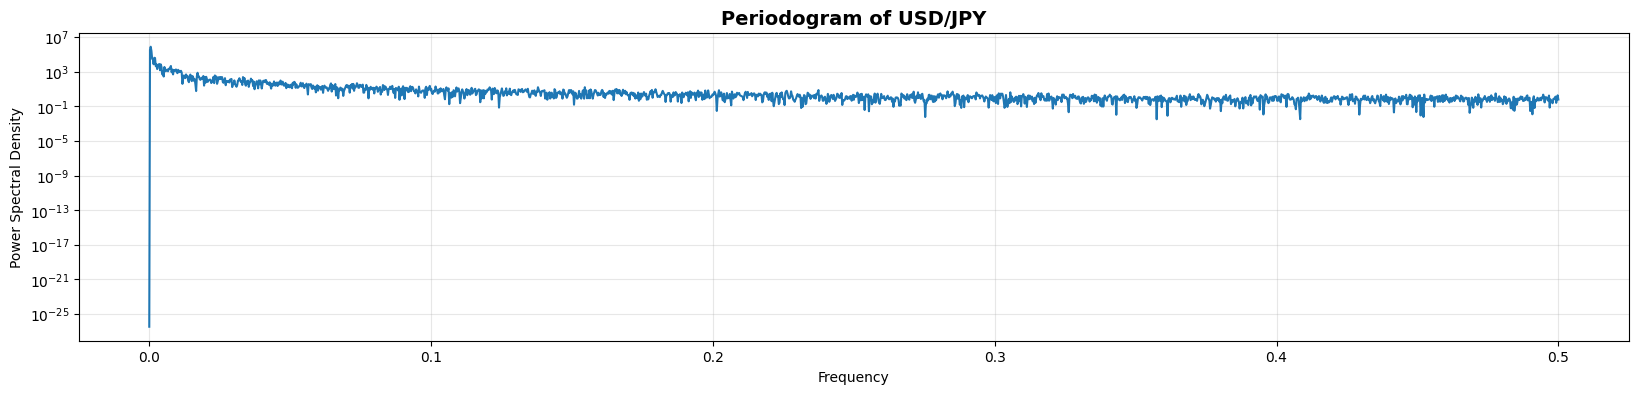

In [11]:
freqs, power = periodogram(data.values.flatten())
plt.figure(figsize=(20, 4))
plt.semilogy(freqs, power)
plt.title("Periodogram of USD/JPY", fontsize=14, fontweight='bold')
plt.xlabel("Frequency")
plt.ylabel("Power Spectral Density")
plt.grid(alpha=0.3)
plt.show()

The periodogram of USD/JPY returns does not display any dominant frequency peak. The spectral density is broadly flat and noisy across frequencies, which is characteristic of a process dominated by stochastic rather than deterministic components. This indicates the absence of any stable seasonal or cyclic periodicity in the FX signal. Consequently, USD/JPY dynamics cannot be explained by deterministic oscillatory behavior and are primarily driven by irregular, regime-dependent macroeconomic shocks.

## 4.2 FFT Insight

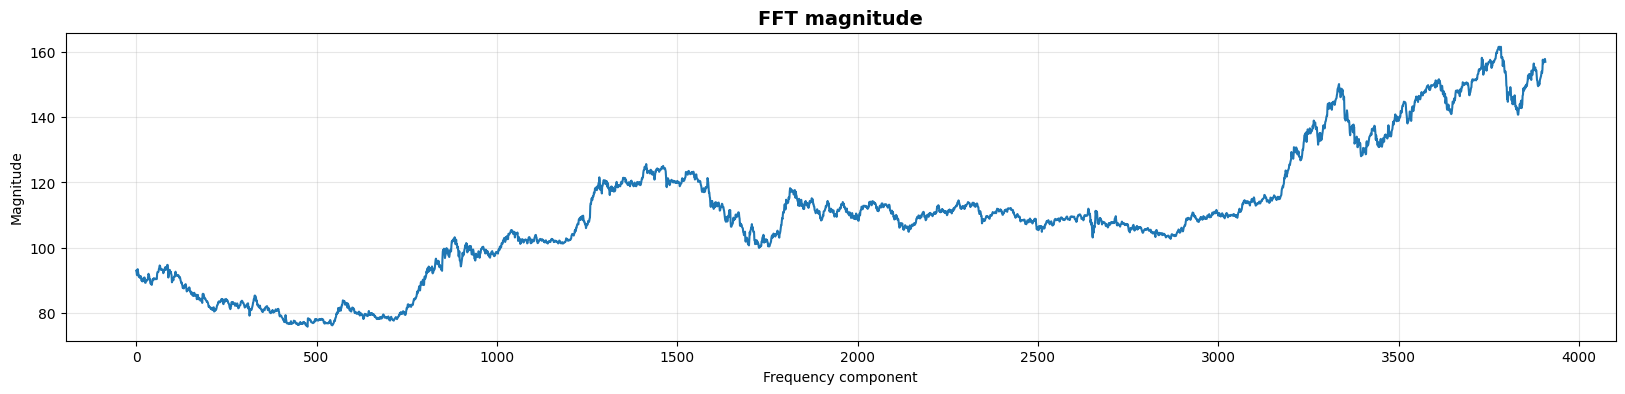

In [12]:
yf_fft = fft(data.values)
plt.figure(figsize=(20, 4))
plt.plot(np.abs(yf_fft))
plt.title("FFT magnitude", fontsize=14, fontweight='bold')
plt.xlabel("Frequency component")
plt.ylabel("Magnitude")
plt.grid(alpha=0.3)
plt.show()

Since the periodogram already shows the absence of dominant frequencies, the raw FFT amplitude does not provide additional structural information and mainly reflects the dominance of low-frequency components driven by the trend. Both representations consistently confirm the absence of strong cyclic behavior in USD/JPY.

# 5. Filtering & Smoothing 
## 5.1 Moving Averages

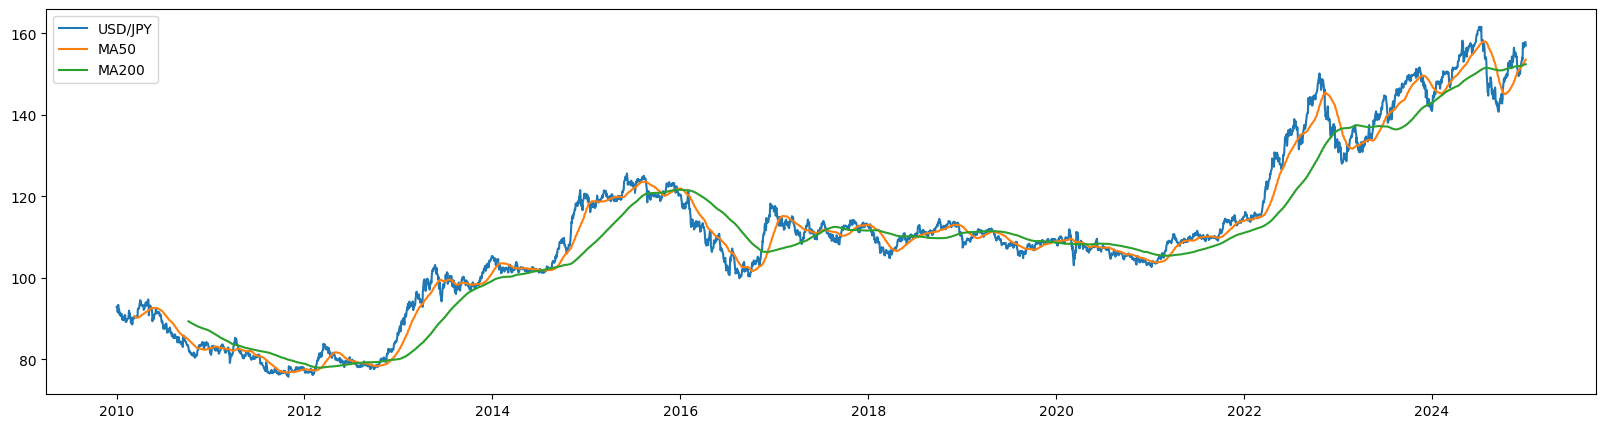

In [13]:
plt.figure(figsize=(20, 5))

ma50 = data.rolling(50).mean()
ma200 = data.rolling(200).mean()

plt.plot(data, label="USD/JPY")
plt.plot(ma50, label="MA50")
plt.plot(ma200, label="MA200")
plt.legend()
plt.show()

The MA50 and MA200 successfully capture the long-term directional regimes of USD/JPY and act as effective low-pass filters that smooth high-frequency noise. However, this smoothing comes at the cost of significant phase distortion, as both moving averages lag the true price dynamics, especially around turning points and regime shifts. As a result, while moving averages are useful descriptive tools for trend identification and regime visualization, they are not suitable for forecasting raw returns or capturing short-term FX dynamics, which are dominated by noise and volatility clustering.

## 5.2 Exponential Smoothing

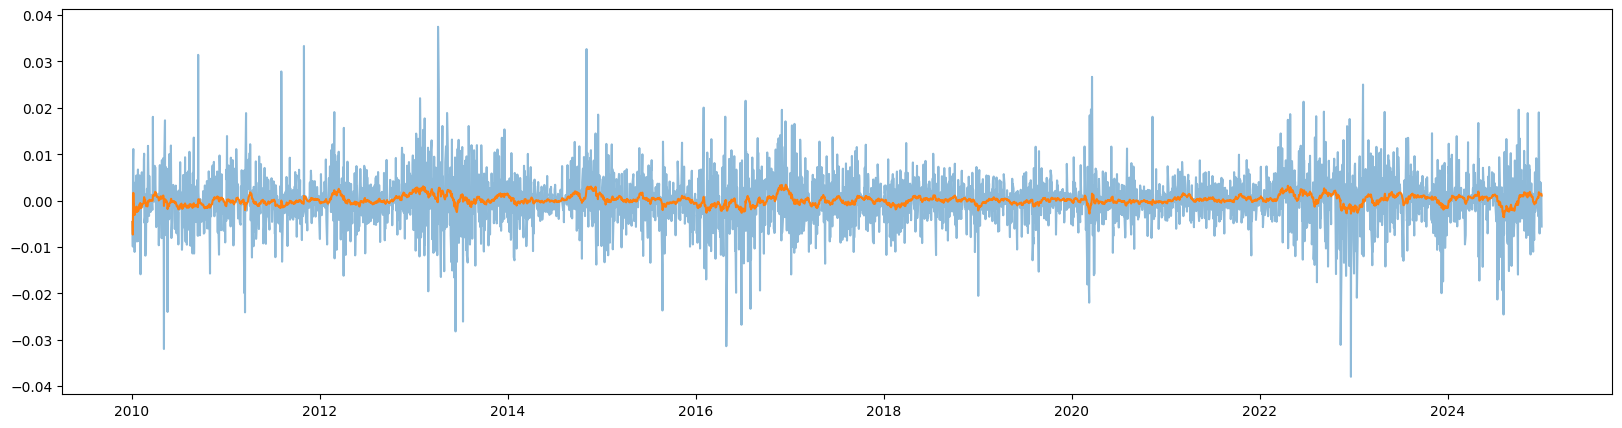

In [14]:
plt.figure(figsize=(20, 5))
alpha = 0.05
exp_smooth = returns.ewm(alpha=alpha).mean()

plt.plot(returns, alpha=0.5)
plt.plot(exp_smooth)
plt.show()

Exponential smoothing reacts faster than simple moving averages due to its higher weight on recent observations. However, despite this increased responsiveness, FX returns remain overwhelmingly dominated by high-frequency noise and volatility clustering. As a result, exponential smoothing is only able to extract very weak short-term structure and offers limited predictive power for return forecasting. Its main usefulness here is descriptive rather than genuinely predictive.

## 5.3 Slutzky–Yule Effect

Demonstrate that smoothing can create fake cycles.

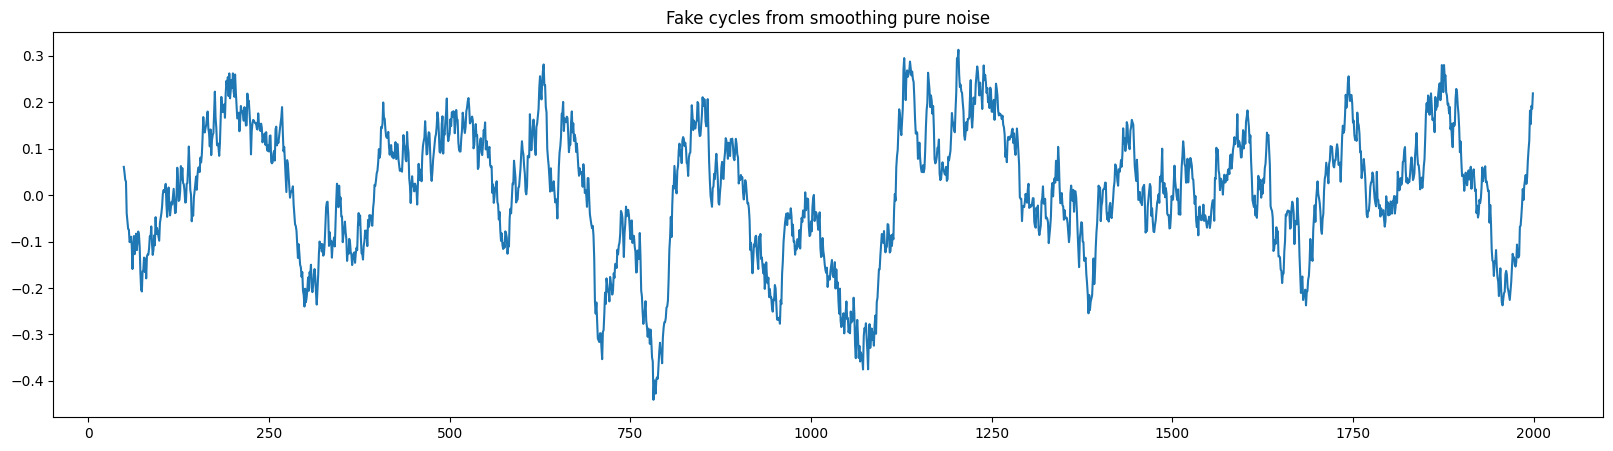

In [15]:
plt.figure(figsize=(20, 5))

noise = np.random.normal(0,1,2000)
noise_ma = pd.Series(noise).rolling(50).mean()

plt.plot(noise_ma)
plt.title("Fake cycles from smoothing pure noise")
plt.show()

Even when applied to pure white noise, smoothing techniques mechanically generate apparent “cycles” and structured oscillations. These patterns are entirely spurious and contain no true predictive information. This illustrates a critical caveat for FX analysis: visual trends obtained through smoothing can be statistical artefacts rather than genuine market structure. Consequently, any interpretation of smoothed FX dynamics must be treated with extreme caution.

# Conclusion

USD/JPY prices are clearly non-stationary, while returns are weakly stationary in mean but strongly heteroskedastic. Linear dependence in returns is extremely limited, no dominant spectral cycles are detected, and smoothing techniques mainly create visual artefacts rather than genuine predictive structure. This confirms that FX dynamics are largely driven by stochastic regime shifts and volatility clustering rather than deterministic trends.

Given the dominance of latent regime effects and time-varying volatility, a state-space representation with recursive filtering naturally follows. This motivates the use of Kalman filtering in Notebook 10.2 to model hidden states and perform optimal real-time estimation.

## 